# TensorFlow Serving

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 10 - Model Deployment/3- Serving_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

TensorFlow Serving is a flexible, high-performance serving system for machine learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data.

# Installation
1. Add TensorFlow Serving distribution URI as a package source (one time setup)

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  15571      0 --:--:-- --:--:-- --:--:-- 15654
OK


2. Install and update TensorFlow ModelServer

In [2]:
!apt-get update
!apt-get install tensorflow-model-server

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/cran

# Import Python Libraries

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The libraries below are built-into python and are used to work with local storage and directories
import os

### Download & Preprocess Data

First, we'll need to download and unzip the images, for that we'll be using the bang `!` keyword to run terminal commands, we'll use `wget` to download and `unzip` to extract files.

In [5]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-18 12:39:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.218.128, 108.177.12.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  89.3MB/s    in 0.7s    

2022-03-18 12:39:48 (89.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [6]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

This is how the dataset directory is laid out:

```
cats_and_dogs_filtered
└───train
│   └───cats
│   │   │   cat.0.jpg
│   │   │   cat.1.jpg
│   │   │   ...
│   └───dogs
│       │   dog.0.jpg
│       │   dog.1.jpg
│       │   ...
└───validation
│   └───cats
│   │   │   cat.2000.jpg
│   │   │   cat.2001.jpg
│   │   │   ...
│   └───dogs
│       │   dog.2000.jpg
│       │   dog.2001.jpg
│       │   ...
```

We'll create a function that takes in the path of either the train or validation folders, loops over the folders and files inside it, and finally return a tuple of the image paths and image labels (i.e. the x's and y's).

In [7]:
def create_cats_vs_dogs_dataset_from_path(path):

    # Create the arrays that will hold the paths and labels
    image_paths = []
    image_labels = []

    # os.listdir returns an array of the files or directories in the specified path
    for dir in os.listdir(path):  # This loops over ['cats', 'dogs']
        for file in os.listdir(
            f"{path}/{dir}"
        ):  # This loops over all the images inside the directoy

            # Create the full path of the image
            image_path = f"{path}/{dir}/{file}"
            # Assign the label depending on the directory, 0 for cats and 1 for dogs
            image_label = 0 if dir == "cats" else 1

            # Append the image path and label to the arrays we defined earlier
            image_paths.append(image_path)
            image_labels.append(image_label)

    # Convert the arrays to Numpy arrays
    image_paths = np.array(image_paths)
    image_labels = np.array(image_labels)

    # Return the tuple
    return image_paths, image_labels

Now we'll use the function above to create the train and testing dataset by passing the path of the train and validation directories respectively.

In [8]:
image_paths_train, labels_train = create_cats_vs_dogs_dataset_from_path(
    "/content/cats_and_dogs_filtered/train"
)
image_paths_test, labels_test = create_cats_vs_dogs_dataset_from_path(
    "/content/cats_and_dogs_filtered/validation"
)

image_paths_train.shape, labels_train.shape, image_paths_test.shape, labels_test.shape

((2000,), (2000,), (1000,), (1000,))

Let's take a look at a few samples from the data we created so far

In [9]:
# We're splicing the middle of the numpy array to get both cats and dogs.
print("Training Image Paths:\n", image_paths_train[995:1005])
print("Training Image Labels:\n", labels_train[995:1005])

Training Image Paths:
 ['/content/cats_and_dogs_filtered/train/dogs/dog.634.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.625.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.735.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.515.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.548.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.640.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.869.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.50.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.384.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.609.jpg']
Training Image Labels:
 [1 1 1 1 1 0 0 0 0 0]


### Create TensorFlow Data Pipeline

Now we're going to define the functions that will be used to create the pipeline, we'll first start with a function that takes an image path and label pair and returns the image tensor and the same label 

In [10]:
def get_image_tensor_from_path(image_path, label):

    image = tf.io.read_file(
        image_path
    )  # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(
        image
    )  # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(
        image, tf.float32
    )  # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(
        image, (224, 224)
    )  # Resize the image to a fixed square size of 224 by 224

    return image, label

Next we'll define the image augmentation function that will apply random transformations to the image

In [11]:
# This is the same function that was defined in the CIFAR10 example


def augment_image(image, label):

    image = tf.image.random_flip_left_right(
        image
    )  # Randomly flip an image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flips an image vertically
    image = tf.image.random_brightness(
        image, max_delta=32.0 / 255.0
    )  # Adjust the brightness of images by a random factor
    image = tf.image.random_saturation(
        image, lower=0.5, upper=1.5
    )  # Adjust the saturation of RGB images by a random factor

    # Make sure the image's pixel values are still between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

And finally, the dataset creator function that will put everything together

In [12]:
def cat_v_dog_dataset_creator(x, y, batch_size=32, training=False):

    data = tf.data.Dataset.from_tensor_slices((x, y))

    # Convert image paths to image tensors using get_image_tensor_from_path
    data = data.map(
        get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    if (
        training
    ):  # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
        data = data.map(
            augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )  # Applying the augment_image function on dataset

    data = data.shuffle(
        2000
    )  # Shuffle the data, `2000` represnts the buffer size, read the documentation for more details
    data = data.batch(batch_size)  # Create mini-batches for the specified size

    # This allows later elements to be prepared while the current element is being processed.
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [13]:
train_dataset = cat_v_dog_dataset_creator(
    image_paths_train, labels_train, training=True
)
test_dataset = cat_v_dog_dataset_creator(image_paths_test, labels_test)

In the cell below, we'll take a batch from the `train_dataset` and show 25 samples from them to see the effect of the transformations.

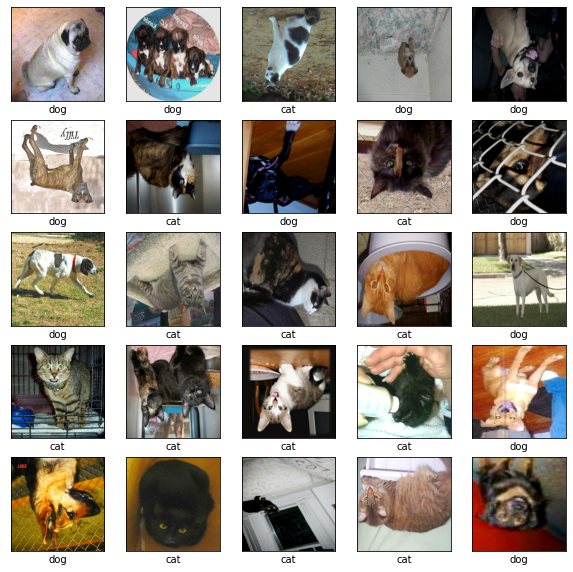

In [14]:
class_names = ["cat", "dog"]

for x, y in train_dataset.take(1):

    plt.figure(figsize=(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)  # Create a subplot on a 5x5 grid for index i

        plt.xticks([])  # Remove the ticks of the number line from the x axis
        plt.yticks([])  # Remove the ticks of the number line from the y axis

        plt.imshow(
            x[i]
        )  # Plot the image, no need to use the cmap parameter since this image is in RGB

        plt.xlabel(class_names[y[i]])  # Add the class name below the image

## Loading Pretrained Model

The usual workflow for transfer learning is the following: 

1. Freeze all layers in the base model by setting trainable = False.
2. Create a new model on top of the output of one (or several) layers from the base model.
3. Train your new model on your new dataset.


Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers from the base model. This is called feature extraction.
3. Use that output as input data for a new, smaller model.

An issue with that workflow, though, is that it doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation, for instance. Transfer learning is typically used for tasks when your new dataset has too little data to train a full-scale model from scratch, and in such scenarios data augmentation is very important. So in what follows, we will focus on the first workflow.

In TensorFlow, we'll start by loading the pretrained model from `tf.keras.applications` API, a full list of available pretrained models can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [15]:
pretrained_model = tf.keras.applications.DenseNet121(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,  # Do not include the ImageNet classifier at the top, we'll only be using the convolutional layers
)

pretrained_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

Notice how there are ~7 millions trainable parameters, since we don't intend to tuning the existing weights, we'll set the `trainable` attribute of the pretrained model to `False` 

In [16]:
pretrained_model.trainable = False
pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

## Build & Train Model
In order to create a new model that leverages the pretrained model, we'll be using TensorFlow's Functional API instead of Sequential, more information on the Functional API can be found here: https://www.tensorflow.org/guide/keras/functional

In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))

# We make sure that the pretrained_model is running in inference mode here by passing `training=False`.
x = pretrained_model(inputs, training=False)

# Flatten the feature vectors to a single vector
x = tf.keras.layers.Flatten()(x)

# Create the feed-forward `Dense` part of the network
x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.1)(x)

# An output layer with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

# Finally create the model by piecing together the layers between the input and output layers
model = tf.keras.Model(inputs, outputs)

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6422656   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13,460,289
Trainable params: 6,422,785
Non-tr

In [24]:
model.compile(
    optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"]
)
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    "/content/Model/1", save_best_only=True
)

In [25]:
model.fit(
    train_dataset, epochs=5, validation_data=test_dataset, callbacks=[save_best_model]
)

Epoch 1/5
63/63 [==============================] - 68s 915ms/step - loss: 2.2233 - accuracy: 0.8290 - val_loss: 0.0370 - val_accuracy: 0.9820
Epoch 2/5
63/63 [==============================] - 64s 948ms/step - loss: 0.0976 - accuracy: 0.9670 - val_loss: 0.0336 - val_accuracy: 0.9850
Epoch 3/5
63/63 [==============================] - 16s 182ms/step - loss: 0.0418 - accuracy: 0.9860 - val_loss: 0.0353 - val_accuracy: 0.9800
Epoch 4/5
63/63 [==============================] - 16s 171ms/step - loss: 0.0188 - accuracy: 0.9970 - val_loss: 0.0439 - val_accuracy: 0.9810
Epoch 5/5
63/63 [==============================] - 16s 169ms/step - loss: 0.0120 - accuracy: 0.9975 - val_loss: 0.0395 - val_accuracy: 0.9830


In comparision, our original model for a validation accuracy of 0.6420 after 20 epoches, so not only did transfer learning increase our model's accuracy, it did so in less training time.

## Plot Training History

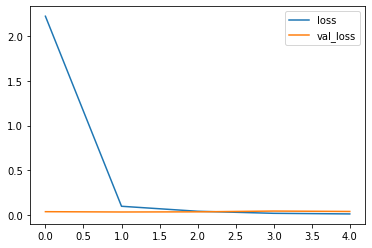

In [26]:
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot.line()

# Deployment
Once the model has been saved using SavedModel format, it is pretty straight forward to get TF-Serving working, if the installation succeeded. Unlike TorchServe, serving ML models in TF-Serving is simpler as you just need to have tensorflow-model-server installed and the ML model in the specified format.

**Flags**:

	--port=8500                      	int32	TCP port to listen on for gRPC/HTTP API. Disabled if port set to zero.
	
	--grpc_socket_path=""            	string	If non-empty, listen to a UNIX socket for gRPC API on the given path. Can be either relative or absolute path.

	--rest_api_port=0                	int32	Port to listen on for HTTP/REST API. If set to zero HTTP/REST API will not be exported. This port must be different than the one specified in --port.

	--rest_api_num_threads=8         	int32	Number of threads for HTTP/REST API processing. If not set, will be auto set based on number of CPUs.

	--rest_api_timeout_in_ms=30000   	int32	Timeout for HTTP/REST API calls.

	--rest_api_enable_cors_support=false	bool	Enable CORS headers in response

	--enable_batching=false          	bool	enable batching

	--allow_version_labels_for_unavailable_models=false	bool	If true, allows assigning unused version labels to models that are not available yet.

	--batching_parameters_file=""    	string	If non-empty, read an ascii BatchingParameters protobuf from the supplied file name and use the contained values instead of the defaults.

	--model_config_file=""           	string	If non-empty, read an ascii ModelServerConfig protobuf from the supplied file name, and serve the models in that file. This config file can be used to specify multiple models to serve and other advanced parameters including non-default version policy. (If used, --model_name, --model_base_path are ignored.)

	--model_config_file_poll_wait_seconds=0	int32	Interval in seconds between each poll of the filesystemfor model_config_file. If unset or set to zero, poll will be done exactly once and not periodically. Setting this to negative is reserved for testing purposes only.

	--model_name="default"           	string	name of model (ignored if --model_config_file flag is set)

	--model_base_path=""             	string	path to export (ignored if --model_config_file flag is set, otherwise required)

	--num_load_threads=0             	int32	The number of threads in the thread-pool used to load servables. If set as 0, we don't use a thread-pool, and servable loads are performed serially in the manager's main work loop, may casue the Serving request to be delayed.
 Default: 0

	--num_unload_threads=0           	int32	The number of threads in the thread-pool used to unload servables. If set as 0, we don't use a thread-pool, and servable loads are performed serially in the manager's main work loop, may casue the Serving request to be delayed. Default: 0

	--max_num_load_retries=5         	int32	maximum number of times it retries loading a model after the first failure, before giving up. If set to 0, a load is attempted only once. Default: 5

	--load_retry_interval_micros=60000000	int64	The interval, in microseconds, between each servable load retry. If set negative, it doesn't wait. Default: 1 minute

	--file_system_poll_wait_seconds=1	int32	Interval in seconds between each poll of the filesystem for new model version. If set to zero poll will be exactly done once and not periodically. Setting this to negative value will disable polling entirely causing ModelServer to indefinitely wait for a new model at startup. Negative values are reserved for testing purposes only.

	--flush_filesystem_caches=true   	bool	If true (the default), filesystem caches will be flushed after the initial load of all servables, and after each subsequent individual servable reload (if the number of load threads is 1). This reduces memory consumption of the model server, at the potential cost of cache misses if model files are accessed after servables are loaded.

	--tensorflow_session_parallelism=0	int64	Number of threads to use for running a Tensorflow session. Auto-configured by default.Note
 that this option is ignored if --platform_config_file is non-empty.

	--tensorflow_session_config_file=""	string	If non-empty, read an ascii TensorFlow Session ConfigProto protobuf from the supplied file name. Note, parts of the session config (threads, parallelism etc.) can be overridden if needed, via corresponding command line flags.

	--tensorflow_intra_op_parallelism=0	int64	Number of threads to use to parallelize the executionof an individual op. Auto-configured by default.Note that this option is ignored if --platform_config_file is non-empty.

	--tensorflow_inter_op_parallelism=0	int64	Controls the number of operators that can be executed simultaneously. Auto-configured by default.Note that this option is ignored if --platform_config_file is non-empty.

	--use_alts_credentials=false     	bool	Use Google ALTS credentials

	--ssl_config_file=""             	string	If non-empty, read an ascii SSLConfig protobuf from the supplied file name and set up a secure gRPC channel

	--platform_config_file=""        	string	If non-empty, read an ascii PlatformConfigMap protobuf from the supplied file name, and use that platform config instead of the Tensorflow platform. (If used, --enable_batching is ignored.)

	--per_process_gpu_memory_fraction=0.000000	float	Fraction that each process occupies of the GPU memory space the value is between 0.0 and 1.0 (with 0.0 as the default) If 1.0, the server will allocate all the memory when the server starts, If 0.0, Tensorflow will automatically select a value.

	--saved_model_tags="serve"       	string	Comma-separated set of tags corresponding to the meta graph def to load from SavedModel.

	--grpc_channel_arguments=""      	string	A comma separated list of arguments to be passed to the grpc server. (e.g. grpc.max_connection_age_ms=2000)

	--grpc_max_threads=8             	int32	Max grpc server threads to handle grpc messages.

	--enable_model_warmup=true       	bool	Enables model warmup, which triggers lazy initializations (such as TF optimizations) at load time, to reduce first request latency.

	--num_request_iterations_for_warmup=0	int32	Number of times a request is iterated during warmup replay. This value is used only if > 0.

	--version=false                  	bool	Display version

	--monitoring_config_file=""      	string	If non-empty, read an ascii MonitoringConfig protobuf from the supplied file name

	--remove_unused_fields_from_bundle_metagraph=true	bool	Removes unused fields from MetaGraphDef proto message to save memory.

	--prefer_tflite_model=false      	bool	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Prefer TensorFlow Lite model from `model.tflite` file in SavedModel directory, instead of the TensorFlow model from `saved_model.pb` file. If no TensorFlow Lite model found, fallback to TensorFlow model.
	
	--num_tflite_pools=2             	int32	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Number of TFLite interpreters in an interpreter pool of TfLiteSession. Typically there is one TfLiteSession for each TF Lite model that is loaded. If not set, will be auto set based on number of CPUs.

	--num_tflite_interpreters_per_pool=1	int32	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Number of TFLite interpreters in an interpreter pool of TfLiteSession. Typically there is one TfLiteSession for each TF Lite model that is loaded. If not set, will be 1.

	--enable_signature_method_name_check=false	bool	Enable method_name check for SignatureDef. Disable this if serving native TF2 regression/classification models.

	--xla_cpu_compilation_enabled=false	bool	EXPERIMENTAL; CAN BE REMOVED ANYTIME! Enable XLA:CPU JIT (default is disabled). With XLA:CPU JIT disabled, models utilizing this feature will return bad Status on first compilation request.

	--enable_profiler=true           	bool	Enable profiler service.
	
	--thread_pool_factory_config_file=""	string	If non-empty, read an ascii ThreadPoolConfig protobuf from the supplied file name.

In [33]:
%%bash --bg 
tensorflow_model_server --port=8500 --rest_api_port=8501 \
                        --model_name=CatVsDog \
                        --model_base_path=/content/Model >server.log 2>&1

Starting job # 2 in a separate thread.


Now, even though the command is clear and self-explanatory, a more detailed explanation on the flags used is presented:
1. port: this is the port to listen on for the gRPC API, the default value is 8500; but it's a common practice to still define this flag's value so as to always know the configuration of the deployed TF-Serving Server.
2. rest_api_port: this is the REST API port, which is set to zero by default, which means that the REST API will not be deployed/exposed unless you manually set a port. There's no default value, it just needs to be different than the gRPC port, so we will set it to 8501 (the next port).
3. model_name: this is the name of the ML model to serve, which is the one that will be exposed in the endpoint.
4. model_base_path: this is the base path where the ML model that is going to be served is placed in. Note that his is the absolute path, do not use relative paths.

In [39]:
# Run the following command to show the server logs
!tail /content/server.log

2022-03-18 13:00:48.444764: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
2022-03-18 13:00:48.501446: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
2022-03-18 13:00:48.528883: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25690112 exceeds 10% of free system memory.
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


# Make Prediction

In [34]:
# import requests to make a prediction
import requests

In [35]:
# create read_image function to read the image from the path
def read_image(
    image_path,
):

    image = tf.io.read_file(
        image_path
    )  # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(
        image
    )  # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(
        image, tf.float32
    )  # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(
        image, (224, 224)
    )  # Resize the image to a fixed square size of 224 by 224

    return image

## Make a request to your model in TensorFlow Serving

**Make REST requests**: newest version of the servable
We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples. We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [45]:
# create predict function to make a prediction
def predictions(path):
    # read the image
    image = read_image(path)
    # add a batch dimension and convert the image to a numpy array
    image = np.expand_dims(image, 0)
    # create a dict object with the image
    data = {"signature_name": "serving_default", "instances": image.tolist()}
    # make a post request to the model server with the data
    json_response = requests.post(
        "http://localhost:8501/v1/models/CatVsDog:predict", json=data
    )
    # convert the json response to a python dictionary
    pred = json_response.json()
    # print the prediction
    print(pred)
    # return the prediction
    return pred["predictions"][0]

In [46]:
# predict the image
predictions("/content/cats_and_dogs_filtered/validation/cats/cat.2009.jpg")

{'predictions': [[0.00820547342]]}


[0.00820547342]